In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [3]:
from IPython.display import Image
from pandas import DataFrame 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname="/home/gezi/soft/simsunttc/msyh.ttf", size=12)  #size可不用指定

In [4]:
import gezi
from libgezi import utf82gbk, gbk2utf8

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
 
flags.DEFINE_string('vocab', '/home/gezi/new/temp/image-caption/lijiaoshou/tfrecord/seq-basic/vocab.txt', 'vocabulary file')
#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.keep100', '')
flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/', '')
#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.ct0', '')

#flags.DEFINE_string('vocab', '/home/gezi/new/temp/image-caption/keyword/tfrecord/seq-basic/vocab.txt', 'vocabulary file')
#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/keyword/model/rnn.lijiaoshou2/', '')

flags.DEFINE_string('seg_method_', 'basic', '')

flags.DEFINE_string('op_name', 'words_importance', 'default is cosine sim importance or encoder_words_importance for maxpooling importance')
#flags.DEFINE_string('op_name', 'encoder_words_importance', 'default is cosine sim importance or encoder_words_importance for maxpooling importance')

import gezi
import melt 
from deepiu.util import text2ids

import numpy as np

text2ids.init(FLAGS.vocab)

predictor = melt.Predictor(FLAGS.model_dir)

def predict(text, text2=None, topn=0):
  text = utf82gbk(text)
  timer = gezi.Timer()
  text_ids = text2ids.text2ids(text, FLAGS.seg_method_, feed_single=True)
  #print('text_ids', text_ids)
    
  if topn:
    #print(tf.get_default_graph().get_all_collection_keys())
    vocab = text2ids.vocab
    scores = predictor.inference('text_words_emb_score', feed_dict = {'rnn/main/text:0': [text_ids]})
    #print(scores)
    scores = scores[0]
    indexes = (-scores).argsort()[:topn]
    print(' '.join(['%s:%.6f'%(gbk2utf8(vocab.key(index)), scores[index]) for index in indexes]))
    return
    
  #print(tf.get_collection('debug_seqeuence'))
  #x  =  predictor.inference(['debug_seqeuence'], index=0,
  #                                  feed_dict= {
  #                                    'rnn/main/text:0': [text_ids]
  #                                    })

  #print(x)
  #return
    
    
  if text2 is not None:
    text2 = utf82gbk(text2)
    text2_ids = text2ids.text2ids(text2, FLAGS.seg_method_, feed_single=True)
    score = predictor.inference('text_emb_sim', 
                                    feed_dict= {
                                      'rnn/main/text:0': [text_ids],
                                      'rnn/main/text2:0': [text2_ids]
                                      #'rnn/main/text2:0':[gezi.pad([1], 50)]
                                      })
    print(score[0], len(score[0]))
    return score[0]

  #seq_len = 50	


  #print('words', words)
  argmax_encode = predictor.inference([FLAGS.op_name], 
                                    feed_dict= {
                                      'rnn/main/text:0': [text_ids]
                                      })
  #print('argmax_encode', argmax_encode[0])
  

  argmax_encode = argmax_encode[0][0]
  #argmax_encode = [max(x, 0) for x in argmax_encode]

  #print('----', len(argmax_encode))

  text_ids =  text2ids.text2ids(text, FLAGS.seg_method_, feed_single=True, append_start=True, append_end=True)
  words = text2ids.ids2words(text_ids)
    
  words = [gbk2utf8(x) for x in words]

  seq_len = 0
  for x in words:
  	if x != 0:
  		seq_len += 1
  	else:
  		break

  #print(text_ids)

   # visualize model
  import matplotlib.pyplot as plt
  #argmaxs = [np.sum((argmax_encode==k)) for k in range(seq_len)]
    
  argmaxs = argmax_encode[:seq_len]
  #print('argmaxs', argmaxs, np.sum(argmaxs), seq_len)
  x = range(len(argmaxs))
  total = sum([x for x in argmaxs if x > 0])
  y = [100.0*n/total for n in argmaxs]
  #print(words, y)
  print(gbk2utf8(text))
  
  #for word, score in zip(words, y):
  #  print(word, score)
  
  fig = plt.figure()
  
  #words = [x.decode('utf8') for x in words]
  #words = [i for i in range(len(words))]

  #plt.xticks(x, words, rotation=45)
  #plt.bar(x, y)
  #plt.ylabel('%')
  #plt.title('Visualisation of words importance')

  df = DataFrame({"%":y}, index=words) 
  ax = df.plot(kind = 'bar', rot = 90) 
  labels = [label.decode("utf-8") for label in df.index.values] 
  ax.set_xticklabels(labels, fontproperties=font) 
    
  #zhfont1 = matplotlib.font_manager.FontProperties(fname='/home/gezi/soft/simsunttc/msyh.ttf')
  #plt.xlabel('性别',fontproperties=zhfont1)
  #plt.ylabel('人数',fontproperties=zhfont1)
  #plt.xticks( (0,1),('男','女') ,fontproperties=zhfont1)
  #plt.bar(left=(0,1), height=(1,0.5), width=0.35)
  
  plt.title('Visualisation of words importance')
  #plt.title('句子词汇重要度')
  plt.show()

tensorflow_version: 1.2.0-rc0
ENCODE_UNK 1
restore from /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-166.3-212000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-166.3-212000


import graph ok /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-166.3-212000.meta
restore ok /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-166.3-212000


In [6]:
def top_words(text, topn=100):
  return predict(text, topn=topn)

In [7]:
top_words('高铁')

铁:0.947550 高:0.545880 动车:0.503490 比重:0.467318 铜棒:0.461579 waki:0.457634 钨:0.447728 磁性:0.446828 宾馆:0.446273 产能:0.435173 友泓:0.431657 江浙:0.431135 bv:0.430136 报废:0.426488 钢轨:0.424668 加热:0.421485 烟壶:0.415830 三角:0.413265 想飞:0.413255 13805194935:0.412684 派发:0.412604 磁棒:0.412318 卓众:0.412036 扫描:0.410286 精度:0.409805 采煤:0.408255 电偶:0.408195 停放:0.407641 箍筋:0.407300 风驰:0.406896 回转:0.406564 电视:0.405777 欧可:0.405470 跳水:0.402534 旋:0.402375 天赐:0.401868 雷:0.400955 恒兴:0.400631 协力:0.400552 盟:0.400450 焊:0.400062 盘扣:0.400002 钯:0.398995 住房:0.398375 组件:0.398078 合金:0.397851 楼房:0.397478 春雨:0.396778 长宏:0.396562 自动:0.396188 永一:0.395787 麦斯:0.395669 敬老:0.395644 运行:0.395508 拆装:0.395442 卡特:0.395382 蒂:0.395070 欧科亚:0.394994 火机:0.394741 huituo:0.394653 声光:0.394233 重机:0.393824 锆:0.393410 沙子:0.392952 航宇:0.392698 手持式:0.392609 加药:0.392422 奥:0.392245 辊:0.392103 亨通:0.391671 灰钙粉:0.391222 安亿:0.391220 dse:0.390829 损耗:0.390624 搬厂:0.389981 步频:0.389670 华迪克:0.389263 舱:0.389161 电梯:0.388999 小松:0.388777 皿:0.388459 安泰:0.388406 座:0.388215

In [8]:
top_words('墨镜')

墨镜:1.000000 轻便:0.506764 开车:0.496520 pet:0.492008 手提:0.491245 音质:0.487361 泼水:0.486774 黄皮:0.481672 副:0.477042 粉底:0.476940 古风:0.474321 桶:0.473891 减肥:0.471902 钛:0.470871 适配:0.470426 开水:0.468474 皮靴:0.465122 档次:0.463888 送友:0.462515 治脱发:0.461767 薄膜:0.461749 开关:0.460779 摔:0.460615 垃圾:0.459141 卸妆:0.454298 鹤:0.453414 车型:0.453111 皮尔兹:0.452468 机芯:0.450612 运动:0.450253 衬托:0.449377 按摩:0.448809 代步:0.448666 电偶:0.447579 狗粮:0.446951 泡妞:0.446073 余款:0.445796 搭讪:0.443783 器:0.443482 卧:0.443280 塑形:0.441800 药水:0.440505 瞳:0.440375 西裤:0.440191 便器:0.439556 将至:0.439071 茶叶:0.438999 暴跌:0.438340 补水:0.437342 组件:0.437245 这时候:0.437240 毫安:0.436434 台球:0.436427 loho:0.436352 太空:0.434521 木瓜:0.434115 众一:0.434060 护肤:0.433733 侧:0.433091 绞股蓝:0.431540 ugg:0.431344 送亲:0.431274 放量:0.430801 马丁:0.430568 追:0.430399 路灯:0.430117 龙海:0.430104 刀锋:0.429731 bmw:0.429726 烟熏:0.429174 箱:0.429009 衣柜:0.428863 夏娃:0.428583 萝卜:0.428208 鞋:0.428181 离心机:0.428057 绝望:0.427943 揭:0.427910 哇:0.427905 板鞋:0.427561 时髦:0.427533 帽:0.427398 华晨:0.427238 窥:0.42683

In [9]:
predict('墨镜', '墨镜')

[ 1.00000024] 1


array([ 1.00000024], dtype=float32)

In [10]:
predict('墨镜', '鼻子')

[ 0.35662287] 1


array([ 0.35662287], dtype=float32)

In [11]:
top_words('美女')

美女:1.000000 裁缝:0.611079 直播:0.558441 主播:0.471892 热辣:0.456038 打牌:0.455171 真人:0.450404 激战:0.431270 开怀:0.428380 交友:0.428015 单身:0.425467 综艺:0.422794 追逐:0.417652 好听:0.413886 婚恋:0.410687 求败:0.410431 鬼怪:0.407527 小丑:0.406003 结识:0.397822 赛鸽:0.397255 播:0.396925 兴许:0.396875 萝:0.396796 秀:0.396383 约会:0.393464 搭讪:0.392498 姐姐:0.391261 娇羞:0.390641 妻子:0.389249 校花:0.389067 喵:0.389025 好转:0.388405 聊天:0.387941 女生:0.387022 特效:0.385848 横着:0.385722 闯过:0.384751 学姐:0.384630 唱歌:0.383052 学长:0.382066 闲聊:0.381482 占尽:0.380434 异性:0.379831 拆机:0.376133 蹲:0.375576 妹子:0.375072 相投:0.374032 勇敢:0.374005 地网:0.373934 收收:0.373554 清纯:0.373257 内向:0.372466 无聊:0.371429 当面:0.370927 误事:0.370806 妹:0.369122 家财:0.369061 睡着:0.368595 同名:0.366605 强人:0.366456 买手:0.364510 相亲:0.363960 视频:0.363775 抢注:0.363736 韩剧:0.362444 小哥:0.362219 科班:0.362072 媒体:0.361736 天兴:0.361551 随地:0.361382 枪战:0.361275 假证:0.360854 新娘:0.360822 拿出:0.360746 爬爬:0.360704 篇:0.360368 结局:0.360130 当红:0.359955 道具:0.359854 误删:0.359557 sci:0.359331 西甲:0.358918 倍率:0.358811 1h:0.35861

iPhone隐藏功能：高铁也能在线选座了！


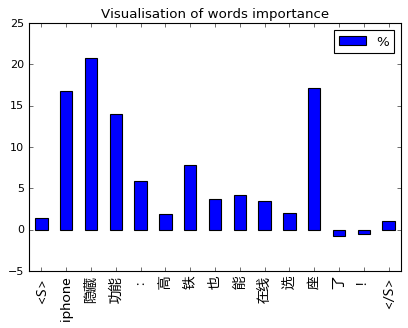

In [12]:
predict('iPhone隐藏功能：高铁也能在线选座了！')

In [13]:
predict('iPhone隐藏功能：高铁也能在线选座了！', 'iPhone')

[ 0.54910505] 1


array([ 0.54910505], dtype=float32)

In [14]:
predict('iPhone隐藏功能：高铁也能在线选座了！', '高铁')

[ 0.49935308] 1


array([ 0.49935308], dtype=float32)

In [15]:
predict('iPhone隐藏功能：高铁也能在线选座了！', '高铁选座')

[ 0.68168753] 1


array([ 0.68168753], dtype=float32)

往返飞旧金山?真是赚了,我一直在这里买!


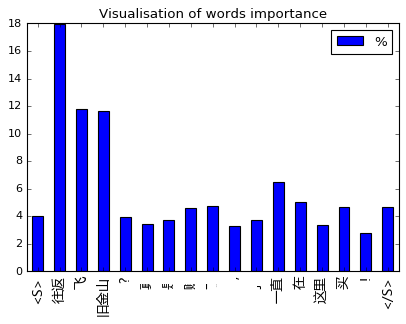

In [16]:
predict('往返飞旧金山?真是赚了,我一直在这里买!')

我的家乡惠州越来越热，选一款喜欢的墨镜很重要


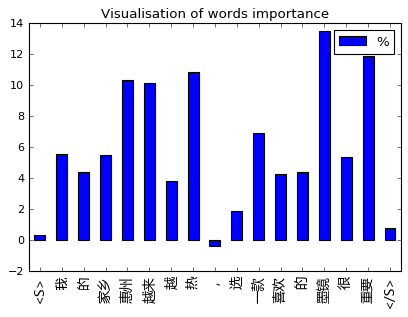

In [17]:
predict('我的家乡惠州越来越热，选一款喜欢的墨镜很重要')

In [18]:
predict('我的家乡惠州越来越热，选一款喜欢的墨镜很重要', '我的家乡惠州越来越热')

[ 0.81742489] 1


array([ 0.81742489], dtype=float32)

In [19]:
predict('我的家乡惠州越来越热，选一款喜欢的墨镜很重要', '选一款喜欢的墨镜很重要')

[ 0.81394154] 1


array([ 0.81394154], dtype=float32)

In [20]:
predict('选一款喜欢的墨镜很重要,我的家乡惠州越来越热', '我的家乡惠州越来越热')

[ 0.79547703] 1


array([ 0.79547703], dtype=float32)

In [21]:
predict('选一款喜欢的墨镜很重要,我的家乡惠州越来越热', '选一款喜欢的墨镜很重要')

[ 0.83753335] 1


array([ 0.83753335], dtype=float32)

我的家乡越来越热，选一款喜欢的墨镜很重要


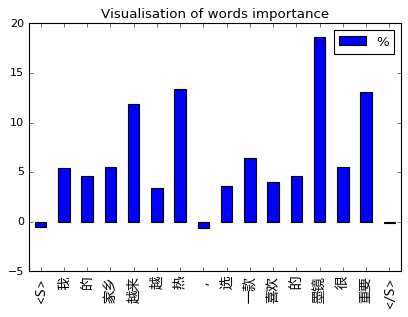

In [22]:
predict('我的家乡越来越热，选一款喜欢的墨镜很重要')

选一款喜欢的墨镜很重要，我的家乡越来越热


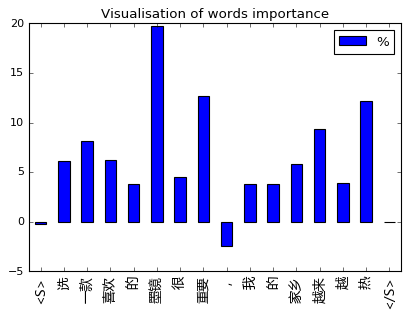

In [23]:
predict('选一款喜欢的墨镜很重要，我的家乡越来越热')

选一款喜欢的墨镜很重要


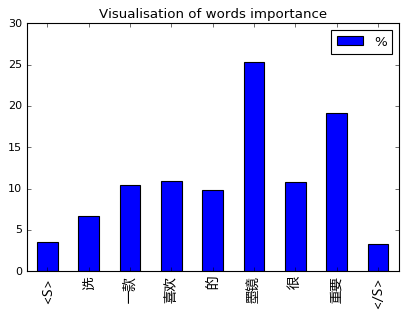

In [24]:
predict('选一款喜欢的墨镜很重要')

不要住酒店，这里的民宿好


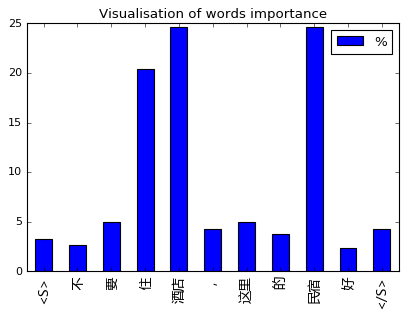

不要住民宿，这里的酒店好


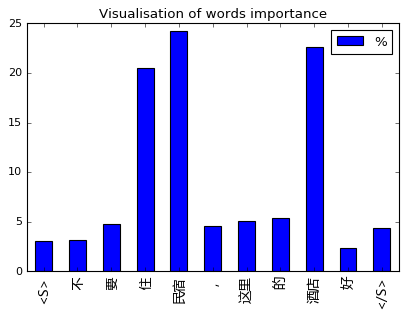

In [25]:
predict('不要住酒店，这里的民宿好')
predict('不要住民宿，这里的酒店好')

In [26]:
top_words('酒店')

酒店:1.000000 格雷斯:0.610321 布草:0.608433 情侣:0.577942 宾馆:0.570946 地毯:0.545997 布置:0.543467 会场:0.533161 喜来登:0.532884 评价:0.529917 会所:0.526232 水疗:0.525833 七彩堂:0.523271 民宿:0.516946 面馆:0.516680 厨房:0.516197 开张:0.515906 菜:0.506989 客房:0.506268 饭店:0.505297 浪漫:0.504949 场地:0.504576 婚庆:0.504512 1700:0.503670 五环:0.502657 海底:0.500763 携程:0.499132 ktv:0.497681 小蓝:0.496075 科勒:0.495767 用品:0.495024 桑拿:0.495007 婚礼:0.494899 办公:0.494513 旅馆:0.491733 餐厅:0.490851 寄卖:0.490771 四合院:0.490408 装修:0.483058 泳池:0.482865 马桶:0.481863 同里:0.481173 食堂:0.480947 度假:0.480706 住:0.479393 三大:0.477496 酒吧:0.477474 游艇:0.477457 古兰:0.477255 游泳:0.476079 嘉宝:0.475516 婚宴:0.474863 间:0.474202 红专:0.474187 enjoy:0.473899 玩偶:0.473597 窗帘:0.472541 炊具:0.472504 醒悟:0.472177 自营:0.472125 池:0.472117 桌椅:0.471557 气派:0.471307 月子:0.467810 会议:0.467075 春游:0.466056 大阪:0.465919 蓝调:0.465249 迪斯尼:0.464434 金翔:0.463510 披萨:0.463267 厨具:0.462625 保洁:0.462520 摊位:0.462180 火锅:0.461519 极小:0.461448 排烟:0.460130 大观:0.459815 平谷:0.457478 万普:0.457456 赏花:0.456994 院子:0.456024 阳春:0.4558

In [27]:
top_words('新加坡')

新加坡:1.000000 service:0.543012 lan:0.480084 来自:0.476984 旧金山:0.467837 左邻:0.464398 香港:0.463257 新山:0.459704 蒂:0.459368 121:0.454798 富力:0.452488 海景:0.450015 ka:0.447289 华侨:0.445632 移民:0.443201 那里:0.438774 旅游:0.436896 欧洲:0.435015 73:0.430812 仙草:0.428639 107:0.428484 l1:0.427769 南沙:0.426409 迪拜:0.426324 7900:0.425721 移居:0.425022 正序:0.422656 三期:0.421838 首尔:0.421707 美国:0.420314 穷游:0.419994 西昌:0.419450 压铸:0.418689 湄公:0.418484 澳洲:0.418050 联展:0.417776 社:0.416271 梅州:0.416240 置业:0.416061 遨游:0.415449 五国:0.414992 清迈:0.412907 汇福:0.412762 1900:0.411303 湖边:0.409525 悦榕:0.409148 富鑫:0.408170 彩票:0.407726 天宸:0.407411 专列:0.407287 马来西亚:0.406384 食材:0.405757 长岛:0.405259 国航:0.404123 爱乐:0.403008 上城:0.402609 芙蓉:0.401976 大阪:0.400501 蚌埠:0.399944 海底:0.399402 7200:0.397989 意大利:0.396855 enomatic:0.396142 57:0.396132 多次:0.395826 各国:0.395258 c1:0.395136 欧元:0.394945 买票:0.394587 芋:0.394357 湾:0.394045 金科:0.393634 自贸区:0.393426 客栈:0.393391 斯玛特:0.393307 领秀:0.392875 〔:0.392715 旁:0.392663 邻:0.392649 航空:0.392130 卧铺:0.391776 甜品:0.390

In [28]:
top_words('民宿')

民宿:1.000000 旅馆:0.555209 海底:0.538259 酒店:0.516946 房产:0.500655 大鹏:0.494913 泳池:0.494499 歇:0.492182 住:0.491283 水杉:0.489580 公寓:0.489483 订房:0.489309 景观:0.486332 游乐:0.485315 峨眉:0.483554 窗帘:0.483077 宾馆:0.482630 涿州:0.481882 风景:0.481734 客栈:0.481158 楼盘:0.480988 承建:0.480649 精装:0.470711 宝安:0.467960 墅:0.467727 乐园:0.467268 城堡:0.465662 渲染:0.464896 康体:0.463268 和美:0.462923 正序:0.462751 星际:0.462071 平谷:0.461716 九寨沟:0.461189 现实:0.461120 别墅:0.460636 装潢:0.459913 独栋:0.459731 看房:0.459026 毛坯:0.458557 金翔:0.457884 豪宅:0.457682 尾盘:0.457255 堵车:0.456444 安居:0.451770 通风:0.451655 双飞:0.451655 江华:0.450305 竟能:0.450282 格雷斯:0.449896 租房:0.449596 装出:0.448767 病人:0.447022 济州:0.446807 度假:0.446371 游玩:0.445657 风情:0.445389 和风:0.444504 旅行:0.443816 绿地:0.443531 繁殖:0.443060 巨龙:0.442144 小狗:0.441649 蒂:0.441056 骑车:0.440852 跳:0.440807 清远:0.440782 梅州:0.440718 水电:0.440448 白鹭:0.440278 汗蒸:0.439857 五环:0.439356 大阪:0.439067 新都:0.438963 龙亭:0.438943 墙纸:0.438775 房:0.438585 地毯:0.437796 雨棚:0.437315 剑侠:0.437111 翻新:0.437089 租车:0.436287 游轮:0.436239 旅游:0.435

In [29]:
top_words('酒店')

酒店:1.000000 格雷斯:0.610321 布草:0.608433 情侣:0.577942 宾馆:0.570946 地毯:0.545997 布置:0.543467 会场:0.533161 喜来登:0.532884 评价:0.529917 会所:0.526232 水疗:0.525833 七彩堂:0.523271 民宿:0.516946 面馆:0.516680 厨房:0.516197 开张:0.515906 菜:0.506989 客房:0.506268 饭店:0.505297 浪漫:0.504949 场地:0.504576 婚庆:0.504512 1700:0.503670 五环:0.502657 海底:0.500763 携程:0.499132 ktv:0.497681 小蓝:0.496075 科勒:0.495767 用品:0.495024 桑拿:0.495007 婚礼:0.494899 办公:0.494513 旅馆:0.491733 餐厅:0.490851 寄卖:0.490771 四合院:0.490408 装修:0.483058 泳池:0.482865 马桶:0.481863 同里:0.481173 食堂:0.480947 度假:0.480706 住:0.479393 三大:0.477496 酒吧:0.477474 游艇:0.477457 古兰:0.477255 游泳:0.476079 嘉宝:0.475516 婚宴:0.474863 间:0.474202 红专:0.474187 enjoy:0.473899 玩偶:0.473597 窗帘:0.472541 炊具:0.472504 醒悟:0.472177 自营:0.472125 池:0.472117 桌椅:0.471557 气派:0.471307 月子:0.467810 会议:0.467075 春游:0.466056 大阪:0.465919 蓝调:0.465249 迪斯尼:0.464434 金翔:0.463510 披萨:0.463267 厨具:0.462625 保洁:0.462520 摊位:0.462180 火锅:0.461519 极小:0.461448 排烟:0.460130 大观:0.459815 平谷:0.457478 万普:0.457456 赏花:0.456994 院子:0.456024 阳春:0.4558

In [30]:
top_words('我的家乡惠州越来越热,选一款喜欢的墨镜很重要')

墨镜:0.607871 惠州:0.528888 波形:0.501609 卷扬机:0.491606 护肤:0.489576 迷人:0.485738 涂塑:0.483110 人防:0.478073 古风:0.472774 电控:0.472656 the:0.469257 康达:0.468253 送友:0.467479 织带:0.467070 台球:0.466766 越来:0.465680 组件:0.463438 电偶:0.463112 宾馆:0.462791 薄膜:0.461258 优品:0.460748 pe管:0.460698 节奏:0.460250 喷嘴:0.460240 收银机:0.460143 开水:0.459842 药水:0.458233 膜:0.457703 落水:0.457469 粉底:0.455838 美甲:0.455757 吉他:0.455485 热:0.455263 香水:0.455232 零食:0.455182 专科:0.455067 给水:0.454955 车载:0.454773 唔:0.454668 滑梯:0.454283 金蝶:0.453719 晾:0.453387 烘箱:0.453301 入手:0.452845 围栏:0.452610 胶带:0.452231 冷弯:0.451861 围网:0.451733 七星:0.451598 土工:0.451432 导电:0.451385 床垫:0.451367 木盒:0.450436 街机:0.450414 衣柜:0.450293 储罐:0.450205 pet:0.450036 grg:0.450032 卷帘:0.449324 管材:0.448770 泰利:0.448734 尽情:0.448352 邦泰:0.448281 送亲:0.448212 乐器:0.448122 结实:0.446997 花子:0.446867 充气:0.446809 冷却:0.446124 压机:0.446038 首先:0.445837 保时捷:0.445760 盒:0.445530 美籍:0.445507 xy:0.445209 酚醛:0.444694 首饰:0.444243 写真:0.443817 探照灯:0.443432 补水:0.442807 卧:0.442058 镀:0.442010 生日:0.441966 整形:

In [31]:
top_words('选一款喜欢的墨镜很重要')

墨镜:0.722156 重要:0.519071 古风:0.496400 上身:0.488405 将至:0.484668 尤其:0.476288 ugg:0.474492 衣柜:0.474297 黄皮:0.470209 帅气:0.468033 送友:0.468007 一款:0.465629 夹克:0.462670 皮尔兹:0.457624 498:0.457363 绒裤:0.457107 斗拱:0.455732 茶叶:0.454817 鞋:0.454294 档次:0.452936 手提:0.451947 衣服:0.451385 表带:0.449947 西裤:0.449413 药水:0.449162 奶瓶:0.447754 项链:0.447562 音质:0.447425 运动:0.447402 送亲:0.447303 地气:0.447044 皮靴:0.446195 松软:0.445364 粉底:0.444811 副:0.444505 吉他:0.444267 绵羊:0.443802 feel:0.443109 入手:0.443016 296:0.442516 西服:0.442036 淡:0.442027 红木:0.440020 腕表:0.437199 台球:0.437056 轻便:0.437029 潮:0.437020 皮鞋:0.436044 胶带:0.435535 loho:0.435476 护肤:0.435304 这时候:0.434468 卸妆:0.434261 免考:0.433849 涂塑:0.432657 佩戴:0.432601 abs:0.432525 千百度:0.431828 麻将:0.430927 补水:0.430502 手表:0.430002 牙齿:0.429961 组件:0.429928 科凡:0.429529 型男:0.429339 喜欢:0.428879 首饰:0.428499 pet:0.428437 蜜蜡:0.427626 文人:0.426996 炉:0.426985 开车:0.426814 大衣:0.426664 落水:0.426538 穿出:0.426157 清爽:0.425894 陆续:0.425588 长相:0.424895 开水:0.424708 宾馆:0.424552 xy:0.424238 打球:0.423792 乐坛:0.4236

In [32]:
top_words('nike')

nike:1.000000 耐克:0.649773 dw:0.503182 金杯:0.494751 平行:0.487849 清障:0.487618 用车:0.487128 正品:0.486659 跑步:0.482209 club:0.481102 徕卡:0.477494 耐卡:0.468835 绅宝:0.467918 威固:0.465915 游艇:0.465567 旅游:0.461373 gox:0.460541 王开:0.458958 一千多:0.456888 air:0.455341 健步:0.454916 com:0.454037 华人:0.450862 专柜:0.450850 专修:0.449806 包天:0.448783 旅行:0.448577 斑马:0.447838 色差:0.447652 海狮:0.447246 风神:0.446910 机芯:0.446754 房车:0.446317 余氯:0.445494 包车:0.443931 五十铃:0.442760 benro:0.442051 母线:0.441248 gia:0.440019 围网:0.439855 上汽:0.438227 美合:0.438191 大巴:0.437323 租车:0.436585 龙粤:0.436443 出海:0.435955 东丽:0.435902 免税:0.434215 奥迪:0.434024 奔驰:0.433943 专卖:0.433801 v80:0.432985 安通:0.432493 华胜:0.432054 游览:0.431923 海康威视:0.431788 toyota:0.431160 手表:0.430815 正方:0.430547 吴氏:0.430235 缤:0.429995 图像:0.429867 潘多拉:0.429369 婚庆:0.429148 g10:0.428636 my:0.428476 斯宾特:0.427872 莱卡:0.427725 折叠:0.427447 清关:0.427287 打球:0.427171 绿地:0.426734 贴膜:0.425419 手环:0.425166 台球:0.424863 汽配:0.424833 童车:0.424601 表带:0.424104 仁恒:0.424098 自行车:0.423098 房贷:0.422738 漫游:0.

In [33]:
top_words('耐克')

耐克:1.000000 nike:0.649773 阿迪:0.554129 专柜:0.543046 名表:0.528796 婚庆:0.499663 三双:0.492731 清障:0.485002 邓禄普:0.480199 专营:0.475459 零食:0.472017 正品:0.471707 婚宴:0.471704 圣诞:0.471155 169:0.467997 悠哉:0.467679 三叶:0.465238 送友:0.464602 鞋:0.464134 奢侈:0.463548 ugg:0.459664 特产:0.457973 送亲:0.452000 车棚:0.450989 296:0.450154 会议:0.449543 奔驰:0.449377 双肩:0.447216 金粤:0.446727 专卖:0.446283 碧桃:0.446041 金面:0.445250 手表:0.445107 gox:0.443900 鞋子:0.443361 水池:0.442569 dw:0.442349 买到:0.441138 凉亭:0.440767 玉柴:0.440729 金杯:0.440543 房贷:0.440291 房车:0.439252 阅:0.438982 旅游:0.438702 美合:0.438536 大牌:0.437791 婚礼:0.436388 停车:0.435638 围栏:0.435031 寄养:0.434478 缅甸:0.432725 紫檀:0.432397 理赔:0.432333 久业:0.432251 再买:0.431892 膜:0.431830 海狮:0.431668 旅行:0.431539 流量:0.431119 百多:0.430104 候车:0.430061 缠绕:0.429980 策划:0.429809 到货:0.429761 骏马:0.429487 跑鞋:0.428641 窖藏:0.427679 老酒:0.427567 摊位:0.427394 年货:0.427371 围网:0.426803 首饰:0.426535 名牌:0.425832 鱼苗:0.425739 呼叫:0.425444 籽料:0.425345 茅台:0.424812 音箱:0.424745 货架:0.424268 威尔:0.423831 租车:0.423663 tcl:0.423514

In [34]:
top_words('重演')

重演:1.000000 色调:0.832589 得体:0.619459 棕色:0.597567 斜纹:0.595088 时尚:0.585835 gxg:0.578509 金丝绒:0.577664 每季:0.576413 裙裤:0.574508 抽象:0.573706 大波:0.572875 款式:0.570924 高领:0.570384 五中:0.566884 翻领:0.564867 新款:0.557308 提花:0.553291 三味:0.543090 毛线:0.540830 通勤:0.539756 面料:0.536976 礼帽:0.536028 jolin:0.534716 柄:0.533446 高傲:0.532910 小方:0.529966 极简:0.529019 两会:0.527346 甜美:0.526334 三人:0.525666 缝制:0.524858 绸:0.523332 碎花:0.522920 定做:0.519601 穿出:0.519375 呢子:0.518754 aj:0.518424 开叉:0.516794 soiree:0.516518 金典:0.515151 利落:0.515032 清货:0.514345 shopping:0.512576 轻盈:0.512388 感性:0.512167 梭:0.511575 女包:0.510393 男装:0.509818 冰丝:0.508653 福泰欣:0.508522 水域:0.507654 考究:0.506937 圆头:0.506838 镂空:0.506451 绒裤:0.505912 颊:0.505062 帅气:0.504709 魅力:0.503530 系带:0.502241 旺销:0.502082 媤:0.500907 奖牌:0.500840 出彩:0.500239 媞:0.499712 身穿:0.499332 尽显:0.499021 条纹:0.498909 格子:0.498159 原单:0.497996 搅:0.497914 春夏:0.497134 小气:0.497102 穿:0.496806 裁衣:0.496077 折扣:0.495797 唇妆:0.492294 越岭:0.491933 腕:0.491172 杰西:0.490774 九牧王:0.490158 两面:0.490017 羚羊:0.489

In [35]:
top_words('电视')

电视:1.000000 液晶:0.620458 kuset:0.614319 彩电:0.550947 广播:0.519533 拼接:0.514893 拆机:0.514356 创奇:0.512640 待命:0.498519 高金:0.494210 步频:0.493916 天线:0.493479 屏:0.490463 tvc:0.490068 富通:0.489838 昮:0.488155 寰:0.487133 显示:0.486278 did:0.485701 可视:0.485539 丹佛:0.482015 影视:0.479425 艺考:0.476852 视:0.476376 赛鸽:0.476214 转椅:0.475786 兆信:0.469975 斯斐德:0.467947 tv:0.467772 if:0.465274 储值:0.460808 m1:0.459307 广告:0.458790 wdp:0.458442 投影:0.458077 神威:0.457175 dtsx:0.455066 华强北:0.454701 触手:0.454326 蒙古:0.452841 维修:0.451989 蒙娜丽莎:0.451965 u盘:0.449418 媒体:0.449400 灏:0.447065 德兰:0.446372 天笔:0.446316 滴胶:0.446130 led:0.446043 海翔:0.445014 吊绳:0.444957 ehs:0.443036 珞珈:0.442985 形势:0.442610 博雅:0.440630 lg:0.439810 电信:0.439433 创捷:0.438740 oracle:0.438583 江民:0.438362 剧:0.437623 中星:0.437465 racol:0.437279 婚照:0.437248 奥委会:0.436761 视听:0.436649 土石方:0.435555 网络:0.434486 创汇:0.434400 可乐:0.433344 雾化:0.432921 深化:0.432242 尊爵:0.431912 布展:0.431057 hdr:0.429741 佳信:0.429583 巧:0.429356 耐圣:0.428850 全彩:0.428849 旗云:0.428576 视频:0.427743 恒美:0.427641

In [36]:
top_words('墨镜')

墨镜:1.000000 轻便:0.506764 开车:0.496520 pet:0.492008 手提:0.491245 音质:0.487361 泼水:0.486774 黄皮:0.481672 副:0.477042 粉底:0.476940 古风:0.474321 桶:0.473891 减肥:0.471902 钛:0.470871 适配:0.470426 开水:0.468474 皮靴:0.465122 档次:0.463888 送友:0.462515 治脱发:0.461767 薄膜:0.461749 开关:0.460779 摔:0.460615 垃圾:0.459141 卸妆:0.454298 鹤:0.453414 车型:0.453111 皮尔兹:0.452468 机芯:0.450612 运动:0.450253 衬托:0.449377 按摩:0.448809 代步:0.448666 电偶:0.447579 狗粮:0.446951 泡妞:0.446073 余款:0.445796 搭讪:0.443783 器:0.443482 卧:0.443280 塑形:0.441800 药水:0.440505 瞳:0.440375 西裤:0.440191 便器:0.439556 将至:0.439071 茶叶:0.438999 暴跌:0.438340 补水:0.437342 组件:0.437245 这时候:0.437240 毫安:0.436434 台球:0.436427 loho:0.436352 太空:0.434521 木瓜:0.434115 众一:0.434060 护肤:0.433733 侧:0.433091 绞股蓝:0.431540 ugg:0.431344 送亲:0.431274 放量:0.430801 马丁:0.430568 追:0.430399 路灯:0.430117 龙海:0.430104 刀锋:0.429731 bmw:0.429726 烟熏:0.429174 箱:0.429009 衣柜:0.428863 夏娃:0.428583 萝卜:0.428208 鞋:0.428181 离心机:0.428057 绝望:0.427943 揭:0.427910 哇:0.427905 板鞋:0.427561 时髦:0.427533 帽:0.427398 华晨:0.427238 窥:0.42683